# Importing Necessary Libraries

In [42]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
from statsmodels.stats.outliers_influence import variance_inflation_factor

# What is PCA?

PCA is a dimensionality reduction technique. It transforms a large set of features into a smaller one 

while keeping as much important information (variance) as possible

# Why use PCA?

To reduce the number of features (especially if they’re correlated). To speed up machine learning models.

To visualize high-dimensional data.

# How does PCA work? (Step-by-step with example)

Imagine you have a dataset with two features: height (in cm) and weight (in kg) of people.

***Step 1: Standardize the data***

Center it around mean = 0 (important if features have different units).

Now height and weight are on the same scale.

***Step 2: Find the covariance matrix***

It shows how height and weight vary with each other.

If they are correlated, PCA can help compress them.

***Step 3: Compute eigenvectors and eigenvalues***

Eigenvectors = new axes/directions (called principal components).

Eigenvalues = how much variance (info) each direction captures.

***Step 4: Choose top principal components***

If height and weight are strongly related, maybe one component captures 95%+ of the info.

So we can drop the second and represent each person with just one number.

***Step 5: Project data onto new axes***

The data is now rotated and represented in terms of principal components (less dimensions, same essence).

# Creating a simple Dataset

In [43]:
np.random.seed(42)
n_samples = 300

# Numerical features
age = np.random.normal(50, 10, n_samples).clip(30, 80)
cholesterol = np.random.normal(200, 30, n_samples)
systolic_bp = np.random.normal(130, 15, n_samples)
bmi = np.random.normal(25, 4, n_samples)

# Gender: "Male" or "Female"
gender = np.random.choice(["Male", "Female"], size=n_samples)

# Smoker: "Yes" or "No"
smoker = np.random.choice(["Yes", "No"], size=n_samples)

# Exercise frequency: encoded numerically
exercise_freq = np.random.choice([0, 1, 2], size=n_samples, p=[0.3, 0.5, 0.2])  # 0 = Rarely, 1 = Sometimes, 2 = Regularly

# Convert gender and smoker to numerical internally for generating risk score
gender_num = (gender == "Male").astype(int)
smoker_num = (smoker == "Yes").astype(int)

# Generate risk score
risk_score = (
    0.03 * age +
    0.02 * cholesterol +
    0.04 * systolic_bp +
    0.05 * bmi +
    2 * smoker_num -
    1.5 * exercise_freq +
    1.0 * gender_num +
    np.random.normal(0, 2, n_samples)  # noise
)

# Define binary target: High risk if score > threshold
threshold = np.percentile(risk_score, 70)  # Top 30% = High Risk
risk = (risk_score >= threshold).astype(int)

# Final DataFrame
data = pd.DataFrame({
    'Age': age,
    'Cholesterol': cholesterol,
    'SystolicBP': systolic_bp,
    'BMI': bmi,
    'Gender': gender,
    'Smoker': smoker,
    'ExerciseFreq': exercise_freq,  # 0 = Rarely, 1 = Sometimes, 2 = Regularly
    'Risk': risk  # Target
})

In [44]:
data

,Age,Cholesterol,SystolicBP,BMI,Gender,Smoker,ExerciseFreq,Risk
0,54.967142,175.130150,141.354829,26.474693,Female,No,2,0
1,48.617357,183.194569,116.167520,23.426645,Male,Yes,1,0
2,56.476885,222.418808,143.044089,25.114979,Female,No,0,0
3,65.230299,218.311108,150.334568,30.113807,Male,No,2,0
4,47.658466,199.372952,136.201524,25.764396,Male,No,2,0
...,...,...,...,...,...,...,...,...
295,43.070904,184.699508,139.730648,26.761899,Male,No,1,0
296,58.995999,191.903752,127.493229,24.921449,Female,Yes,1,0
297,53.072995,170.637089,132.200705,27.209960,Female,No,2,0
298,58.128621,186.671202,148.097634,25.895657,Male,No,1,0


# Encode categorical variables

***Using one hot encoding***

In [45]:
# One-hot encode Gender and School
encoded = pd.get_dummies(data[['Gender', 'Smoker']], drop_first=True).astype(int)


In [46]:
encoded.columns

Index(['Gender_Male', 'Smoker_Yes'], dtype='object')

# Combining the encoded vectors

In [47]:
features = pd.concat([data, encoded], axis=1)
features = features.drop(['Risk','Gender','Smoker'],axis=1)
labels = data['Risk']

In [48]:
features = features.rename(columns={"Gender_Male": "Gender", "Smoker_Yes": "Smoker"})

In [49]:
labels

0      0
1      0
2      0
3      0
4      0
      ..
295    0
296    0
297    0
298    0
299    1
Name: Risk, Length: 300, dtype: int32

# Standardize features

In [50]:
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

In [51]:
features

,Age,Cholesterol,SystolicBP,BMI,ExerciseFreq,Gender,Smoker
0,54.967142,175.130150,141.354829,26.474693,2,0,0
1,48.617357,183.194569,116.167520,23.426645,1,1,1
2,56.476885,222.418808,143.044089,25.114979,0,0,0
3,65.230299,218.311108,150.334568,30.113807,2,1,0
4,47.658466,199.372952,136.201524,25.764396,2,1,0
...,...,...,...,...,...,...,...
295,43.070904,184.699508,139.730648,26.761899,1,1,0
296,58.995999,191.903752,127.493229,24.921449,1,0,1
297,53.072995,170.637089,132.200705,27.209960,2,0,0
298,58.128621,186.671202,148.097634,25.895657,1,1,0


# Creating a VIF (Variance Inflation Factor) Dataframe

In [52]:
vif_data = pd.DataFrame()
vif_data["Feature"] = features.columns


In [53]:
vif_data["VIF"] = [variance_inflation_factor(features.values, i) for i in range(features.shape[1])]

In [82]:
vif_data

,Feature,VIF
0,Age,25.748176
1,Cholesterol,35.435442
2,SystolicBP,46.227845
3,BMI,33.076078
4,ExerciseFreq,2.784117
5,Gender,1.909734
6,Smoker,2.000532


## VIF Interpretation – What it Means:

1. High VIF (typically > 10):

    Means the feature is highly correlated with other features.

    Example: SystolicBP with a VIF of ~46 → it can be predicted from a combination of the other variables. This reduces the model's interpretability and stability.

2. Low VIF (1–5):

    Features like Gender, Smoker, and ExerciseFreq have low VIF → they're not linearly dependent on other features.

    They bring unique information to the model and are safe to keep.

# Apply PCA

In [54]:
pca = PCA(n_components=3)
X_pca = pca.fit_transform(features_scaled)

In [55]:
X_pca.shape

(300, 3)

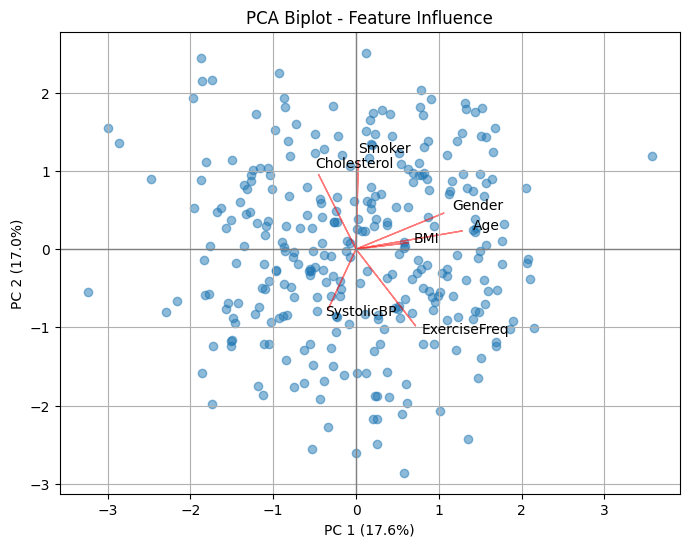

In [56]:
# Get percentage of variance explained
explained_var = pca.explained_variance_ratio_

components = pca.components_
feature_names = features.columns

plt.figure(figsize=(8, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], alpha=0.5)
for i, feature in enumerate(feature_names):
    plt.arrow(0, 0, components[0, i]*2, components[1, i]*2, color='red', alpha=0.5)
    plt.text(components[0, i]*2.2, components[1, i]*2.2, feature, color='black')
plt.xlabel(f'PC 1 ({explained_var[0]*100:.1f}%)')
plt.ylabel(f'PC 2 ({explained_var[1]*100:.1f}%)')
plt.title('PCA Biplot - Feature Influence')
plt.axhline(0, color='gray', lw=1)
plt.axvline(0, color='gray', lw=1)
plt.grid(True)
plt.show()


# Graph Conclusion

The smaller the angle between two arrows, the higher their positive correlation.

The larger the angle (closer to 180°), the stronger their negative correlation.

An angle near 90° means the features are uncorrelated.


## 1. Positively Correlated Features (arrows point in similar direction)

***BMI, Cholesterol, and Smoker_Yes:***

These arrows are close together and point in a similar upward direction (along PC2 and PC3).

**Interpretation**: These features are positively correlated — people with high BMI also tend to have high cholesterol and are more likely to be smokers.

***Age and Gender_Male:***

Point in the same general direction along PC1.

**Interpretation**: Males in this dataset may tend to be older, or age distribution might differ by gender.

## 2. Negatively Correlated Features (arrows point in opposite directions)

***ExerciseFreq vs. BMI, Cholesterol, and Smoker_Yes:***

ExerciseFreq points in the opposite direction.

**Interpretation**: People who exercise more tend to have lower BMI, lower cholesterol, and are less likely to be smokers — a negative correlation.

## 3. Uncorrelated or Weakly Related Features (90° angles)

***SystolicBP is somewhat orthogonal (right angle) to Smoker_Yes and Gender_Male.***

**Interpretation**: It’s less strongly correlated with those variables — maybe it varies independently in your dataset.

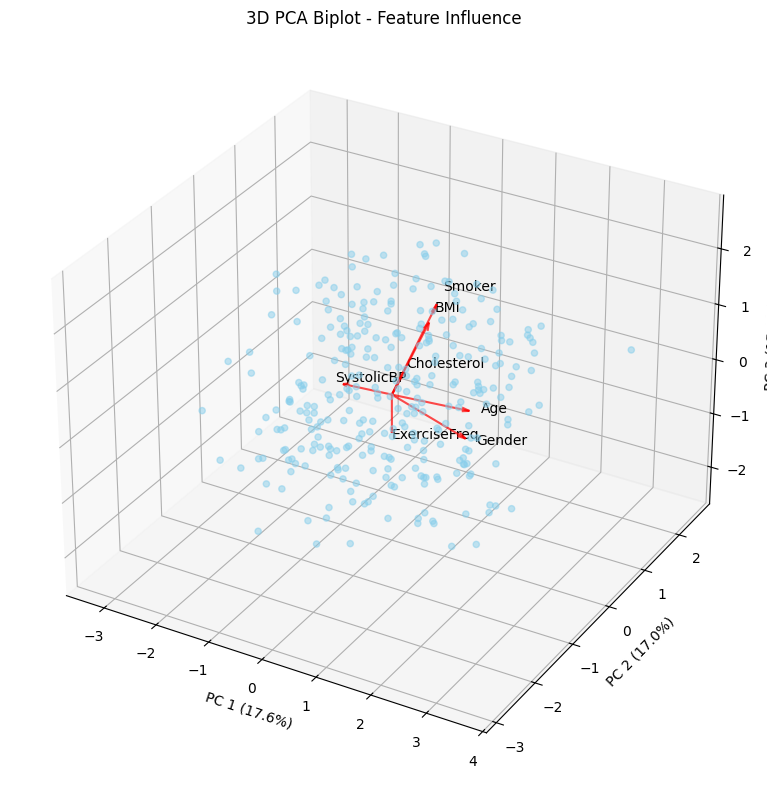

In [57]:
# 3D Graph with all the Principle Components

explained_var = pca.explained_variance_ratio_
components = pca.components_
feature_names = features.columns

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# 3D scatter of the PCA-reduced data
ax.scatter(X_pca[:, 0], X_pca[:, 1], X_pca[:, 2], alpha=0.5, c='skyblue')

# Draw arrows representing original features
for i, feature in enumerate(feature_names):
    ax.quiver(0, 0, 0,
              components[0, i]*2,
              components[1, i]*2,
              components[2, i]*2,
              color='red', arrow_length_ratio=0.1, alpha=0.7)
    ax.text(components[0, i]*2.3,
            components[1, i]*2.3,
            components[2, i]*2.3,
            feature, color='black')

# Axis labels
ax.set_xlabel(f'PC 1 ({explained_var[0]*100:.1f}%)')
ax.set_ylabel(f'PC 2 ({explained_var[1]*100:.1f}%)')
ax.set_zlabel(f'PC 3 ({explained_var[2]*100:.1f}%)')
ax.set_title('3D PCA Biplot - Feature Influence')

plt.tight_layout()
plt.show()

***Variance captured by each component***

In [58]:
explained_variance = pd.DataFrame({
    'Principal Component': [f'PC{i+1}' for i in range(len(pca.explained_variance_ratio_))],
    'Explained Variance (%)': pca.explained_variance_ratio_ * 100
})

In [59]:
explained_variance

,Principal Component,Explained Variance (%)
0,PC1,17.619600
1,PC2,17.040390
2,PC3,15.056706


# Performing Train-Test-Split

In [60]:
# splitting the dataset into training and testing variables
X_train, X_test, y_train, y_test = train_test_split(X_pca, labels, test_size=0.3, random_state=42)

In [61]:
features.columns

Index(['Age', 'Cholesterol', 'SystolicBP', 'BMI', 'ExerciseFreq', 'Gender',
       'Smoker'],
      dtype='object')

# Training a minimul Classifier model

In [62]:
model = LogisticRegression()
model.fit(X_train, y_train)

LogisticRegression()

In [63]:
y_pred = model.predict(X_test)
print("\nClassification Report:")
print(classification_report(y_test, y_pred))


Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.90      0.86        72
           1       0.36      0.22      0.28        18

    accuracy                           0.77        90
   macro avg       0.59      0.56      0.57        90
weighted avg       0.73      0.77      0.74        90



# Dumping the models as Pickle package

In [64]:
import joblib
joblib.dump(model,"model.pkl")
joblib.dump(scaler,"scalar.pkl")
joblib.dump(pca,"pca.pkl")

['pca.pkl']

In [65]:
# --- Load your trained model and scaler (update path as needed)
trained_model = joblib.load("model.pkl")        # Trained classifier
scaler_transformer = joblib.load("scalar.pkl")              # StandardScaler
pca_component = joblib.load("pca.pkl") 

In [74]:
age = int(input("Age: "))
cholesterol = float(input("Cholesterol: "))
systolic_bp = float(input("Systolic Blood Pressure: "))
bmi = float(input("BMI: "))

gender_input = input("Gender (Male/Female): ").strip().capitalize()
gender = 1 if gender_input == "Male" else 0

smoker_input = input("Smoker (Yes/No): ").strip().capitalize()
smoker = 1 if smoker_input == "Yes" else 0

exercise_freq = int(input("Exercise Frequency (0=Rarely, 1=Sometimes, 2=Regularly): "))

# ------------------------------
# 3. Build DataFrame
# ------------------------------
user_input_dict = {
    'Age': age,
    'Cholesterol': cholesterol,
    'SystolicBP': systolic_bp,
    'BMI': bmi,
    'ExerciseFreq': exercise_freq,
    'Gender': gender,
    'Smoker': smoker,
    
}

In [75]:
user_input_dict

{'Age': 20,
 'Cholesterol': 70.0,
 'SystolicBP': 120.0,
 'BMI': 55.0,
 'ExerciseFreq': 2,
 'Gender': 1,
 'Smoker': 0}

In [76]:
# ----------------------
# Create a DataFrame
#-----------------------
user_df = pd.DataFrame([user_input_dict])

In [77]:
user_df

,Age,Cholesterol,SystolicBP,BMI,ExerciseFreq,Gender,Smoker
0,20,70.0,120.0,55.0,2,1,0


In [78]:
user_scaled = scaler_transformer.transform(user_df)

In [79]:
user_pca = pca_component.transform(user_scaled)


In [80]:
user_pca

array([[ 2.56762073, -2.97003056,  4.9361149 ]])

In [81]:
risk_prediction = trained_model.predict(user_pca)[0]
print(f"Predicted Risk Level: {risk_prediction}")

Predicted Risk Level: 0
